In [82]:
import pandahouse as ph
import numpy as np
import seaborn as sns
from matplotlib import pyplot

In [70]:
connection_default = {'host': 'http://clickhouse.beslan.pro:8080',
                      'database':'default',
                      'user':'student', 
                      'password':'dpo_python_2020'
                     }

In [3]:
connection_test = dict(database='test',
                  host='http://clickhouse.beslan.pro:8080',
                  user='student-rw',
                  password='656e2b0c9c')

In [10]:
# создаем запрос, db автоматически заменится на значение из database
q = '''
    SELECT 
        UserID 
    FROM 
        {db}.checks 
    LIMIT 10
    '''

# отправляем запрос и записываем результат в пандасовский датафрейм
q_test = ph.read_clickhouse(query=q, connection=connection_default)

### Задание 1. 
#### Для начала, проверим правильность подключения к ClickHouse через pandahouse, отправив простой запрос: выведите количество строк в таблице ldn_listings

In [14]:
ldn = '''
        SELECT 
            count()
        FROM
            {db}.ldn_listings
      '''
df = ph.read_clickhouse(query=ldn,connection=connection_default)
df

,count()
0,85207


In [56]:
price_room = '''
             SELECT
                 toFloat32OrNull(replaceRegexpAll(price, '[$,]','')) AS price,
                 room_type
             FROM
                 {db}.ldn_listings
             ORDER BY
                 id ASC
             LIMIT 1000
             '''

df_room = ph.read_clickhouse(query=price_room, connection=connection_default)

In [58]:
df_room.groupby('room_type', as_index=False) \
       .agg({'price': lambda x: x.quantile(0.75)})

,room_type,price
0,Entire home/apt,160.00
1,Hotel room,157.00
2,Private room,70.00
3,Shared room,69.25


In [59]:
df_room.query('room_type == "Private room"') \
       .groupby('room_type',as_index=False) \
       .quantile(0.75)

,room_type,price
0,Private room,70.0


### Задание 2.
#### К данным о цене и типе комнаты дополнительно выгрузите данные о рейтинге жилья (review_scores_rating). В запросе необходимо будет отфильтровать пустые значения review_scores_rating и сконвертировать эту колонку в тип float32.
#### Сгруппируйте датафрейм по типу жилья и посчитайте среднее для цены и рейтинга (не забудьте привести рейтинг к типу float)
#### Используйте sns.scatterplot, чтобы построить график рассеивания средней цены (ось X) и рейтинга (ось Y) c разбивкой по типу жилья (параметр hue)

In [9]:
query_room = '''
SELECT
    toFloat32OrNull(review_scores_rating) AS review_rating,
    toFloat32OrNull(replaceRegexpAll(price, '[$,]','')) AS price,
    room_type
FROM ldn_listings
WHERE review_rating is not null
ORDER BY id DESC
LIMIT 1000
'''
df = ph.read_clickhouse(query=query_room, connection=connection_default)

In [10]:
mean_room = df.groupby('room_type', as_index=False).agg({'review_rating' : 'mean', 'price' : 'mean'})

In [11]:
mean_room

,room_type,review_rating,price
0,Entire home/apt,90.101639,174.808197
1,Private room,90.798958,65.738907
2,Shared room,97.142860,450.285706


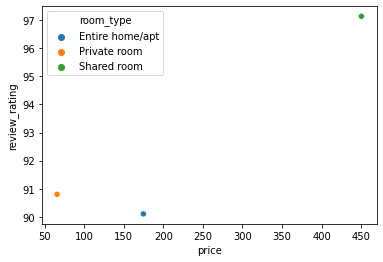

In [85]:
sns.scatterplot(data=mean_room, x='price', y='review_rating', hue='room_type')

### Задание 3.

#### Проверим, какие способы верификации аккаунта использовали хозяева, предлагающие различные впечатления (experiences_offered != 'none'). Для каждого уникального пользователя выгрузите только две колонки:

- host_id - идентификатор хозяина (уникальный)
- host_verifications - какими способами хост подтвердил свой профиль

#### Затем обработайте столбец host_verifications: В ячейках находятся строковые представления списка (например, как результат str([1, 2, 3])). Приведите их к настоящему списку, где в качестве элементов будут храниться использованные способы подтверждения аккаунта: 

- "['email', 'phone', 'facebook']" -> ['email', 'phone', 'facebook']

#### Используйте методы explode и value_counts, чтобы посчитать, сколько раз встречается каждый способ верификации
#### Сколько хозяев подтвердили профиль с помощью аккаунта Google?


In [30]:
hoby = '''SELECT
            DISTINCT host_id,
            host_verifications
         FROM
            ldn_listings
         WHERE 
             experiences_offered != 'none'
      '''
df_hoby = ph.read_clickhouse(query=hoby, connection=connection_default)

In [31]:
df_hoby.host_verifications = df_hoby.host_verifications.apply(lambda x: x.strip('[]').replace(',', '').split())

In [32]:
df_hoby.head(2)

,host_id,host_verifications
0,54730,"['email', 'phone', 'facebook', 'reviews', 'off..."
1,60302,"['email', 'phone', 'reviews', 'jumio', 'govern..."


In [33]:
df_hoby.host_verifications.explode().value_counts()

'phone'                    1361
'email'                    1345
'reviews'                  1309
'government_id'            1196
'jumio'                    1115
'offline_government_id'     469
'work_email'                279
'facebook'                  270
'selfie'                    252
'identity_manual'           227
'manual_offline'             70
'google'                     34
'kba'                        27
'manual_online'              16
'sent_id'                     6
Name: host_verifications, dtype: int64

### Задание 4.

#### Теперь посмотрим, для скольких объявлений и в каких районах хозяева указали впечатления. Сгруппируйте данные по району и виду впечатления и посчитайте количество объявлений. Новый столбец назовите experiences_count.

#### Отсортируйте данные по убыванию experiences_count и выгрузите первые 100 строк. Затем преобразуйте данные с помощью pivot, поместив в индексы название района, столбцы – вид впечатления, а значения – число объявлений с таким впечатлением для каждого района. Визуализируйте результат с помощью sns.heatmap() c палитрой cmap=sns.cubehelix_palette(as_cmap=True). 

In [54]:
room = '''
       SELECT
           neighbourhood_cleansed,
           experiences_offered,
           count(*) AS experiences_count
       FROM
           ldn_listings
       WHERE
           experiences_offered != 'none'
       GROUP BY
           neighbourhood_cleansed, experiences_offered
       ORDER BY 
           experiences_count DESC
       LIMIT 100
       '''
df = ph.read_clickhouse(query=room, connection=connection_default)

In [58]:
df_frame = df.pivot(index='neighbourhood_cleansed', columns='experiences_offered', values='experiences_count')

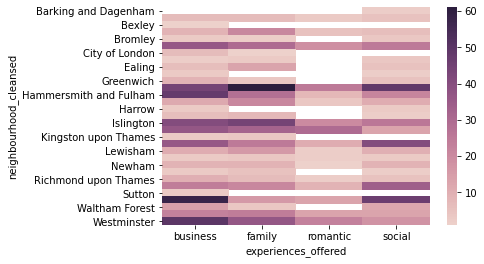

In [63]:
sns.heatmap(df_frame, cmap=sns.cubehelix_palette(as_cmap=True))

### Задание 4.

#### Выгрузите данные о ценах за ночь для разных типов жилья, для которых также доступен какой-либо вид впечатления. Необходимые для составления запроса столбцы:
- room_type – тип сдаваемого жилья (доступные варианты: Entire home/apt, Private room, Hotel room, Shared room)
- price – цена за ночь 
- experiences_offered – вид доступного впечатления (оставить не 'none')

#### Далее постройте два графика, используя distplot из библиотеки seaborn:
- На первом отобразите исходные распределения цен для каждого типа жилья
- На втором – логарифмированные значения (np.log())

In [65]:
room_offered = '''
               SELECT
                   room_type,
                   toFloat32OrNull(replaceRegexpAll(price, '[$,]','')) AS price_corr
               FROM
                   ldn_listings
               WHERE
                   experiences_offered != 'none'
               '''
df = ph.read_clickhouse(query=room_offered, connection=connection_default)

In [77]:
df.room_type.value_counts()

Entire home/apt    922
Private room       613
Shared room          9
Hotel room           4
Name: room_type, dtype: int64

/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


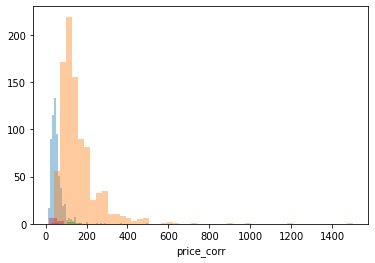

In [89]:
for data in df.room_type.unique():
    sns.distplot(df[df.room_type == data].price_corr, kde=False)

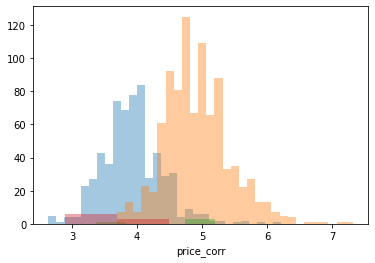

In [90]:
for data in df.room_type.unique():
    sns.distplot(np.log(df[df.room_type == data].price_corr), kde=False)

### Задание 5.

#### Выгрузите данные о цене, типе жилья и дате первого отзыва, начиная со 2 января 2010 года. Ограничение поставьте на 1000 строк. Необходимые столбцы:

- room_type – тип сдаваемого жилья (доступные варианты: Entire home/apt, Private room, Hotel room, Shared room)
- price – цена за ночь
- first_review – дата первого отзыва (отфильтровать по правилу "строго больше 2010-01-01")

#### Используя библиотеку seaborn и функцию lineplot, постройте график динамики средних цен на жилье (ось Y) в зависимости от типа комнаты (цвет линии, параметр 'hue') по годам (ось X). Датафрейм должен быть отсортирован по годам.

#### Удалите последние 6 символов у значений в столбце даты, чтобы получить год, например, с помощью применения lambda-функции.

In [117]:
room_first = '''
             SELECT
                 room_type,
                 toFloat32OrNull(replaceRegexpAll(price, '[$,]','')) AS price_corr,
                 first_review
             FROM
                 ldn_listings
             WHERE first_review > '2010-01-01'
             LIMIT 1000
             '''
df = ph.read_clickhouse(query=room_first, connection=connection_default)

In [118]:
df.first_review = df.first_review.apply(lambda x: x.split('-')[:-2]).explode()

In [119]:
df

,room_type,price_corr,first_review
0,Private room,65.0,2010
1,Entire home/apt,300.0,2011
2,Entire home/apt,65.0,2016
3,Private room,29.0,2010
4,Private room,100.0,2010
...,...,...,...
995,Private room,45.0,2012
996,Private room,51.0,2013
997,Entire home/apt,79.0,2012
998,Entire home/apt,110.0,2012


In [122]:
mean_df = df.groupby(['room_type', 'first_review'], as_index=False) \
  .agg({'price_corr' : 'mean'}) \
  .sort_values('first_review', ascending=True)

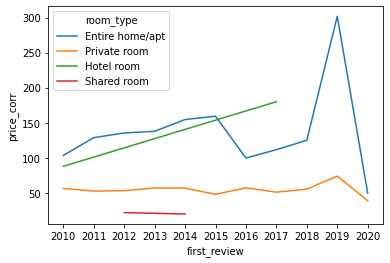

In [124]:
sns.lineplot(x='first_review',y='price_corr',hue='room_type',data=mean_df)